## Modeling - Classifying Book Cover by Decade Published
> This was using 5 total decades

#### This notebook was run in Google Colab

In [35]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import class_weight

np.random.seed(42)

In [ ]:
!unzip /content/drive/MyDrive/datasets/capstone/images.zip

In [3]:
train = pd.read_csv('/content/drive/MyDrive/datasets/capstone/data/train_2_cleaned.csv', index_col=0)
test = pd.read_csv('/content/drive/MyDrive/datasets/capstone/data/test_2_cleaned.csv', index_col=0)

In [5]:
train.head(3)

,amazon_index,filename,title,author,category_id,category,meta,year,meta_author,decade
0,1588345297,1588345297.jpg,With Schwarzkopf: Life Lessons of The Bear,Gus Lee,1,Biographies & Memoirs,"{""ISBN-13"": ""9781588345295"", ""Title"": ""With Sc...",2015,Gus Lee,2010
1,1404803335,1404803335.jpg,"Magnets: Pulling Together, Pushing Apart (Amaz...",Natalie M. Rosinsky,4,Children's Books,"{""ISBN-13"": ""9781404803336"", ""Title"": ""Magnets...",2002,Natalie M. Rosinsky,2000
2,471310115,0471310115.jpg,"Janice VanCleave's 201 Awesome, Magical, Bizar...",Janice VanCleave,4,Children's Books,"{""ISBN-13"": ""9780471310112"", ""Title"": ""Janice ...",1994,Janice VanCleave,1990


In [6]:
test.head(3)

,amazon_index,filename,title,author,category_id,category,meta,year,meta_author,decade
0,60750715,0060750715.jpg,George Balanchine: The Ballet Maker (Eminent L...,Robert Gottlieb,1,Biographies & Memoirs,"{""ISBN-13"": ""9780060750701"", ""Title"": ""George ...",2004,Robert Gottlieb,2000
1,312556411,0312556411.jpg,Literature and Its Writers: A Compact Introduc...,Ann Charters,15,Literature & Fiction,"{""ISBN-13"": ""9781457606472"", ""Title"": ""Literat...",2012,Ann Charters,2010
2,545700272,0545700272.jpg,A Handful of Stars,Cynthia Lord,4,Children's Books,"{""ISBN-13"": ""9780545700283"", ""Title"": ""A Handf...",2017,Cynthia Lord,2010


In [4]:
train['decade'] = train['decade'].astype('str')
test['decade'] = test['decade'].astype('str')

### Baseline Model

In [ ]:
train['decade'].value_counts(normalize=True)

2010    0.585719
2000    0.251179
1990    0.126577
1980    0.026544
2020    0.009981
Name: decade, dtype: float64

In [ ]:
test['decade'].value_counts(normalize=True)

2010    0.591398
2000    0.258065
1990    0.123167
1980    0.021505
2020    0.005865
Name: decade, dtype: float64

#### Importing Images

In [6]:
datagen = ImageDataGenerator(rescale=1/255)

In [7]:
train_gen = datagen.flow_from_dataframe(
    dataframe=train,
    directory='/content/224x224',
    x_col='filename',
    y_col='decade',
    class_mode='categorical',
    target_size=(256,256)
)

test_gen = datagen.flow_from_dataframe(
    dataframe=test,
    directory='/content/224x224',
    x_col='filename',
    y_col='decade',
    class_mode='categorical',
    target_size=(256,256),
    shuffle=False
)

Found 9117 validated image filenames belonging to 5 classes.
Found 1023 validated image filenames belonging to 5 classes.


### First Model with 5 Categories

In [8]:
model1 = Sequential()
model1.add(Conv2D(64,(3,3),activation='relu',input_shape=(256,256,3)))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(64,(3,3),activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())
model1.add(Dense(64,activation='relu'))
model1.add(Dense(5,activation='softmax'))

model1.compile(
    optimizer ='adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [9]:
history1 = model1.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10
)

Epoch 1/10
285/285 [==============================] - 70s 201ms/step - loss: 1.2391 - accuracy: 0.5830 - val_loss: 1.0982 - val_accuracy: 0.5934
Epoch 2/10
285/285 [==============================] - 51s 179ms/step - loss: 0.9696 - accuracy: 0.6041 - val_loss: 0.9742 - val_accuracy: 0.6041
Epoch 3/10
285/285 [==============================] - 54s 191ms/step - loss: 0.7296 - accuracy: 0.6967 - val_loss: 0.9961 - val_accuracy: 0.5797
Epoch 4/10
285/285 [==============================] - 51s 179ms/step - loss: 0.4264 - accuracy: 0.8276 - val_loss: 1.2888 - val_accuracy: 0.5503
Epoch 5/10
285/285 [==============================] - 44s 155ms/step - loss: 0.2140 - accuracy: 0.9241 - val_loss: 2.0309 - val_accuracy: 0.6276
Epoch 6/10
285/285 [==============================] - 52s 180ms/step - loss: 0.1145 - accuracy: 0.9667 - val_loss: 2.3362 - val_accuracy: 0.5924
Epoch 7/10
285/285 [==============================] - 56s 197ms/step - loss: 0.0515 - accuracy: 0.9862 - val_loss: 3.0303 - val_ac

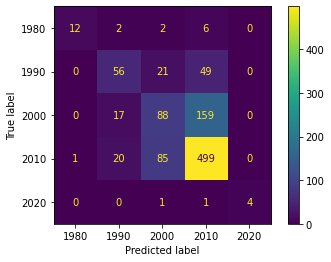

In [10]:
ConfusionMatrixDisplay.from_predictions(
    test_gen.classes, 
    np.argmax(model1.predict(test_gen), axis=1), 
    display_labels=list(test_gen.class_indices.keys()));

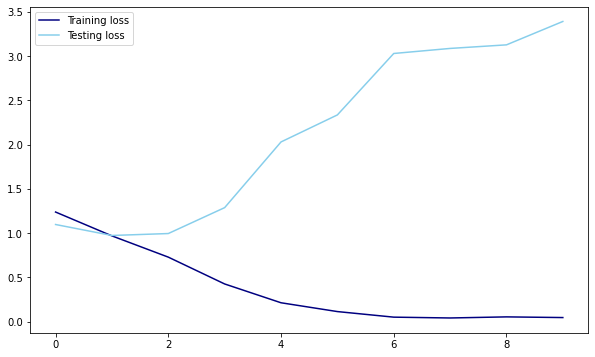

In [11]:
train_loss = history1.history['loss']
test_loss = history1.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

### Adding Additional Conv2D and MaxPooling 2D Layers with Dropout and Early Stopping

In [12]:
model2 = Sequential()
model2.add(Conv2D(64,(3,3),activation='relu',input_shape=(256,256,3)))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(64,(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(64,(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(64,(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())
model2.add(Dense(64,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(5,activation='softmax'))

model2.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [13]:
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
)

In [14]:
history2 = model2.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
285/285 [==============================] - 38s 129ms/step - loss: 1.0822 - accuracy: 0.5818 - val_loss: 1.0321 - val_accuracy: 0.5914
Epoch 2/10
285/285 [==============================] - 42s 146ms/step - loss: 1.0525 - accuracy: 0.5848 - val_loss: 1.0216 - val_accuracy: 0.5914
Epoch 3/10
285/285 [==============================] - 45s 158ms/step - loss: 1.0389 - accuracy: 0.5850 - val_loss: 1.0118 - val_accuracy: 0.5914
Epoch 4/10
285/285 [==============================] - 48s 167ms/step - loss: 1.0268 - accuracy: 0.5877 - val_loss: 1.0061 - val_accuracy: 0.5885
Epoch 5/10
285/285 [==============================] - 49s 170ms/step - loss: 1.0083 - accuracy: 0.5914 - val_loss: 1.0122 - val_accuracy: 0.5914
Epoch 6/10
285/285 [==============================] - 52s 181ms/step - loss: 0.9886 - accuracy: 0.5949 - val_loss: 1.0205 - val_accuracy: 0.5904
Epoch 7/10
285/285 [==============================] - 39s 136ms/step - loss: 0.9651 - accuracy: 0.6027 - val_loss: 1.0068 - val_ac

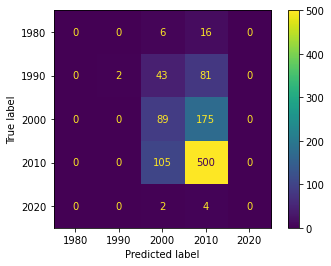

In [15]:
ConfusionMatrixDisplay.from_predictions(
    test_gen.classes, 
    np.argmax(model2.predict(test_gen), axis=1), 
    display_labels=list(test_gen.class_indices.keys()));

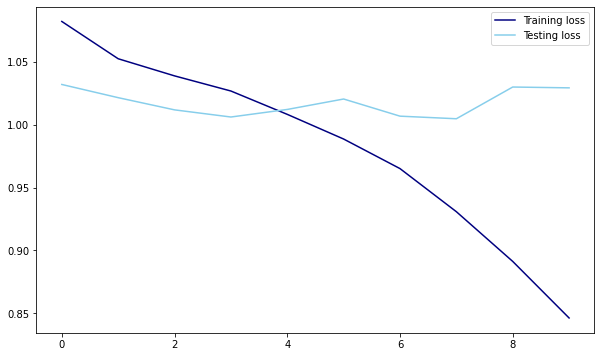

In [16]:
train_loss = history2.history['loss']
test_loss = history2.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

#### Adding Extra Conv2D and MaxPooling2D Layer

In [17]:
model3 = Sequential()
model3.add(Conv2D(64,(3,3),activation='relu',input_shape=(256,256,3)))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(64,(3,3),activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(64,(3,3),activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Flatten())
model3.add(Dense(64,activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(5,activation='softmax'))

model3.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [18]:
history3 = model3.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
285/285 [==============================] - 34s 116ms/step - loss: 1.0766 - accuracy: 0.5784 - val_loss: 1.0289 - val_accuracy: 0.5924
Epoch 2/10
285/285 [==============================] - 33s 116ms/step - loss: 1.0301 - accuracy: 0.5878 - val_loss: 1.0066 - val_accuracy: 0.5904
Epoch 3/10
285/285 [==============================] - 32s 113ms/step - loss: 0.9748 - accuracy: 0.6049 - val_loss: 0.9879 - val_accuracy: 0.5885
Epoch 4/10
285/285 [==============================] - 33s 117ms/step - loss: 0.9082 - accuracy: 0.6208 - val_loss: 1.0141 - val_accuracy: 0.5924
Epoch 5/10
285/285 [==============================] - 32s 113ms/step - loss: 0.8322 - accuracy: 0.6541 - val_loss: 1.0344 - val_accuracy: 0.5934
Epoch 6/10
285/285 [==============================] - 32s 111ms/step - loss: 0.7402 - accuracy: 0.6962 - val_loss: 0.9844 - val_accuracy: 0.5738
Epoch 7/10
285/285 [==============================] - 33s 114ms/step - loss: 0.6351 - accuracy: 0.7363 - val_loss: 1.0161 - val_ac

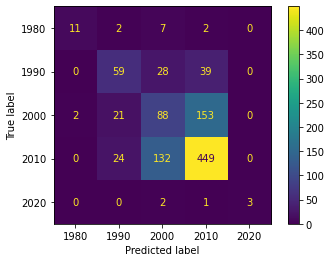

In [19]:
ConfusionMatrixDisplay.from_predictions(
    test_gen.classes, 
    np.argmax(model3.predict(test_gen), axis=1), 
    display_labels=list(test_gen.class_indices.keys()));

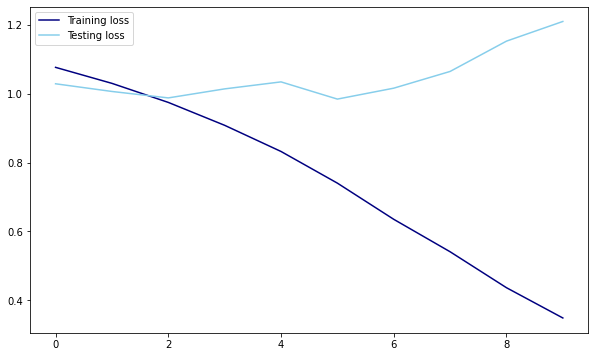

In [36]:
train_loss = history3.history['loss']
test_loss = history3.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

#### Changing neurons in layers

In [20]:
model4 = Sequential()
model4.add(Conv2D(80,(3,3),activation='relu',input_shape=(256,256,3)))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Conv2D(70,(3,3),activation='relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Conv2D(64,(3,3),activation='relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Flatten())
model4.add(Dense(50,activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(5,activation='softmax'))

model4.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [21]:
history4 = model4.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
285/285 [==============================] - 36s 124ms/step - loss: 1.0785 - accuracy: 0.5825 - val_loss: 1.0168 - val_accuracy: 0.5914
Epoch 2/10
285/285 [==============================] - 34s 120ms/step - loss: 1.0342 - accuracy: 0.5855 - val_loss: 1.0075 - val_accuracy: 0.5934
Epoch 3/10
285/285 [==============================] - 35s 122ms/step - loss: 1.0009 - accuracy: 0.5884 - val_loss: 1.0236 - val_accuracy: 0.5934
Epoch 4/10
285/285 [==============================] - 37s 128ms/step - loss: 0.9511 - accuracy: 0.6020 - val_loss: 1.0177 - val_accuracy: 0.5640
Epoch 5/10
285/285 [==============================] - 35s 121ms/step - loss: 0.8899 - accuracy: 0.6196 - val_loss: 0.9793 - val_accuracy: 0.5826
Epoch 6/10
285/285 [==============================] - 34s 120ms/step - loss: 0.8097 - accuracy: 0.6493 - val_loss: 0.9736 - val_accuracy: 0.5826
Epoch 7/10
285/285 [==============================] - 35s 123ms/step - loss: 0.7189 - accuracy: 0.6931 - val_loss: 1.0269 - val_ac

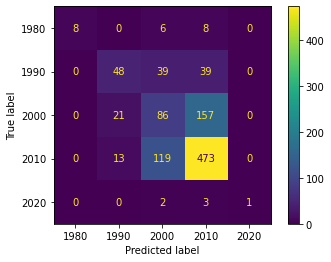

In [22]:
ConfusionMatrixDisplay.from_predictions(
    test_gen.classes, 
    np.argmax(model4.predict(test_gen), axis=1), 
    display_labels=list(test_gen.class_indices.keys()));

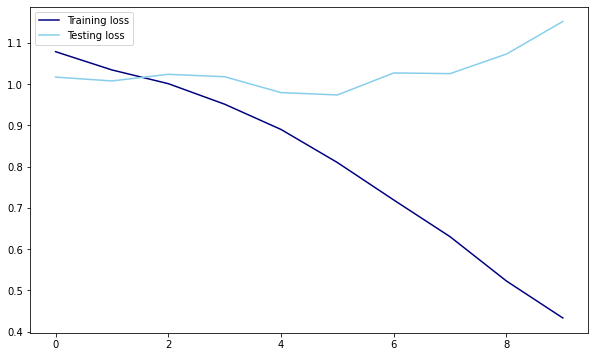

In [37]:
train_loss = history4.history['loss']
test_loss = history4.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

### Data Augmentation

In [23]:
aug_train_gen = ImageDataGenerator(rescale=1/255, vertical_flip=True, rotation_range=20)
aug_test_gen = ImageDataGenerator(rescale=1/225, vertical_flip=True, rotation_range=20)

In [24]:
aug_train = aug_train_gen.flow_from_dataframe(
    dataframe=train,
    directory='/content/224x224',
    x_col='filename',
    y_col='decade',
    class_mode='categorical'
)

aug_test = aug_test_gen.flow_from_dataframe(
    dataframe=test,
    directory='/content/224x224',
    x_col='filename',
    y_col='decade',
    class_mode='categorical',
    shuffle=False
)

Found 9117 validated image filenames belonging to 5 classes.
Found 1023 validated image filenames belonging to 5 classes.


In [25]:
model5 = Sequential()
model5.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model5.add(MaxPool2D(pool_size=(2,2)))

model5.add(Flatten())
model5.add(Dense(units=100, activation='relu'))
model5.add(Dense(units=5, activation='softmax'))

model5.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [26]:
history5 = model5.fit(
    aug_train,
    batch_size=32,
    validation_data=aug_test,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
285/285 [==============================] - 151s 530ms/step - loss: 1.3264 - accuracy: 0.5243 - val_loss: 1.9107 - val_accuracy: 0.3206
Epoch 2/10
285/285 [==============================] - 148s 519ms/step - loss: 1.1395 - accuracy: 0.5613 - val_loss: 1.0780 - val_accuracy: 0.5415
Epoch 3/10
285/285 [==============================] - 151s 531ms/step - loss: 1.0663 - accuracy: 0.5799 - val_loss: 1.0687 - val_accuracy: 0.5543
Epoch 4/10
285/285 [==============================] - 151s 531ms/step - loss: 1.0535 - accuracy: 0.5877 - val_loss: 1.0662 - val_accuracy: 0.5934
Epoch 5/10
285/285 [==============================] - 151s 529ms/step - loss: 1.0294 - accuracy: 0.5944 - val_loss: 1.0873 - val_accuracy: 0.5934
Epoch 6/10
285/285 [==============================] - 150s 525ms/step - loss: 1.0175 - accuracy: 0.5932 - val_loss: 1.0626 - val_accuracy: 0.5826
Epoch 7/10
285/285 [==============================] - 148s 520ms/step - loss: 1.0126 - accuracy: 0.5937 - val_loss: 1.0645 -

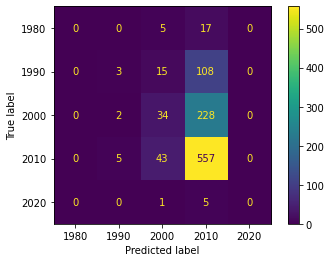

In [27]:
ConfusionMatrixDisplay.from_predictions(
    aug_test.classes, 
    np.argmax(model5.predict(aug_test), axis=1), 
    display_labels=list(aug_test.class_indices.keys()));

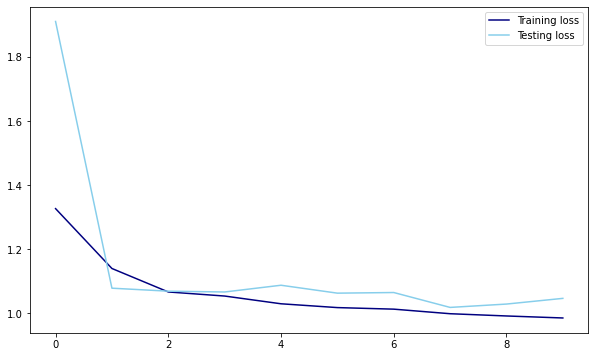

In [38]:
train_loss = history5.history['loss']
test_loss = history5.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

#### Data Augmentation - Adding Additional Conv2D and MaxPool2D Layer

In [28]:
model6 = Sequential()
model6.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model6.add(MaxPool2D(pool_size=(2,2)))

model6.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model6.add(MaxPool2D(pool_size=(2,2)))

model6.add(Flatten())
model6.add(Dense(units=100, activation='relu'))
model6.add(Dense(units=5, activation='softmax'))

model6.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [29]:
history6 = model6.fit(
    aug_train,
    batch_size=32,
    validation_data=aug_test,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
285/285 [==============================] - 169s 590ms/step - loss: 1.0875 - accuracy: 0.5811 - val_loss: 1.0441 - val_accuracy: 0.5924
Epoch 2/10
285/285 [==============================] - 157s 552ms/step - loss: 1.0493 - accuracy: 0.5869 - val_loss: 1.0391 - val_accuracy: 0.5914
Epoch 3/10
285/285 [==============================] - 158s 554ms/step - loss: 1.0302 - accuracy: 0.5873 - val_loss: 1.0347 - val_accuracy: 0.5943
Epoch 4/10
285/285 [==============================] - 158s 554ms/step - loss: 1.0176 - accuracy: 0.5918 - val_loss: 1.0261 - val_accuracy: 0.5953
Epoch 5/10
285/285 [==============================] - 160s 561ms/step - loss: 1.0021 - accuracy: 0.5939 - val_loss: 1.0306 - val_accuracy: 0.5885
Epoch 6/10
285/285 [==============================] - 160s 562ms/step - loss: 0.9871 - accuracy: 0.5996 - val_loss: 1.0474 - val_accuracy: 0.5963
Epoch 7/10
285/285 [==============================] - 159s 560ms/step - loss: 0.9703 - accuracy: 0.6046 - val_loss: 1.0465 -

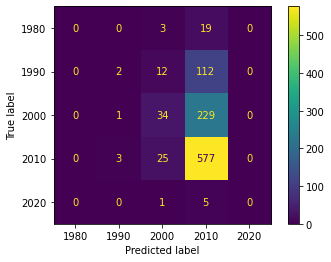

In [30]:
ConfusionMatrixDisplay.from_predictions(
    aug_test.classes, 
    np.argmax(model6.predict(aug_test), axis=1), 
    display_labels=list(aug_test.class_indices.keys()));

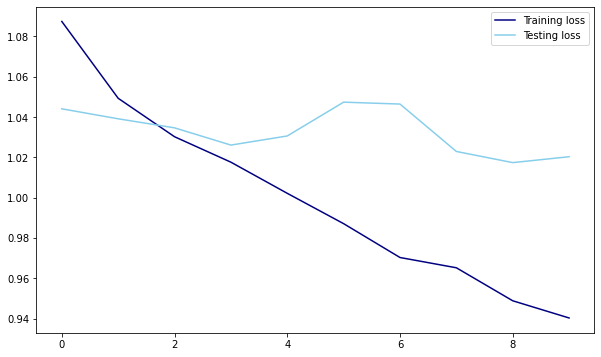

In [39]:
train_loss = history6.history['loss']
test_loss = history6.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

In [31]:
model7 = Sequential()
model7.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model7.add(MaxPool2D(pool_size=(2,2)))

model7.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model7.add(MaxPool2D(pool_size=(2,2)))

model7.add(Flatten())
model7.add(Dense(units=100, activation='relu'))
model7.add(Dense(units=5, activation='softmax'))

model7.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [32]:
history7 = model7.fit(
    aug_train,
    batch_size=32,
    validation_data=aug_test,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
285/285 [==============================] - 159s 555ms/step - loss: 1.3144 - accuracy: 0.5768 - val_loss: 1.0323 - val_accuracy: 0.5914
Epoch 2/10
285/285 [==============================] - 160s 561ms/step - loss: 1.0797 - accuracy: 0.5854 - val_loss: 1.0235 - val_accuracy: 0.5914
Epoch 3/10
285/285 [==============================] - 161s 566ms/step - loss: 1.0510 - accuracy: 0.5882 - val_loss: 1.0183 - val_accuracy: 0.5982
Epoch 4/10
285/285 [==============================] - 161s 566ms/step - loss: 1.0459 - accuracy: 0.5893 - val_loss: 1.0234 - val_accuracy: 0.5982
Epoch 5/10
285/285 [==============================] - 163s 571ms/step - loss: 1.0356 - accuracy: 0.5921 - val_loss: 1.0400 - val_accuracy: 0.6002
Epoch 6/10
285/285 [==============================] - 167s 585ms/step - loss: 1.0286 - accuracy: 0.5925 - val_loss: 1.0250 - val_accuracy: 0.5894
Epoch 7/10
285/285 [==============================] - 170s 595ms/step - loss: 1.0226 - accuracy: 0.5938 - val_loss: 1.0128 -

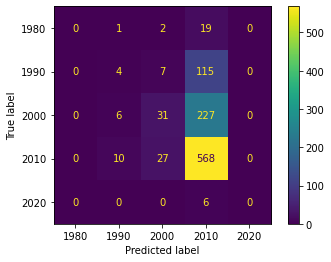

In [33]:
ConfusionMatrixDisplay.from_predictions(
    aug_test.classes, 
    np.argmax(model7.predict(aug_test), axis=1), 
    display_labels=list(aug_test.class_indices.keys()));

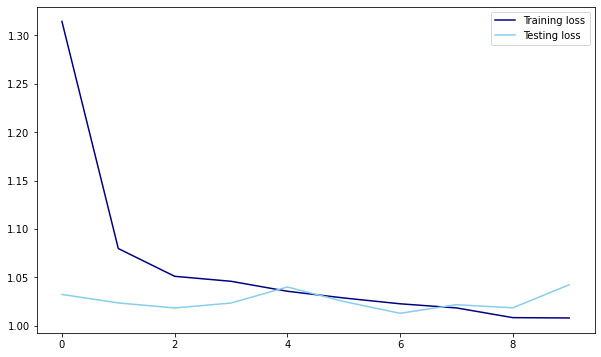

In [40]:
train_loss = history7.history['loss']
test_loss = history7.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

In [41]:
model8 = Sequential()
model8.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_regularizer=l2(0.001)))
model8.add(MaxPool2D(pool_size=(2,2)))

model8.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',kernel_regularizer=l2(0.001)))
model8.add(MaxPool2D(pool_size=(2,2)))

model8.add(Flatten())
model8.add(Dense(units=100, activation='relu', kernel_regularizer=l2(0.001)))
model8.add(Dense(units=5, activation='softmax', kernel_regularizer=l2(0.001)))

model8.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [42]:
history8 = model8.fit(
    aug_train,
    batch_size=32,
    validation_data=aug_test,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
285/285 [==============================] - 174s 605ms/step - loss: 1.4077 - accuracy: 0.5638 - val_loss: 1.1242 - val_accuracy: 0.5904
Epoch 2/10
285/285 [==============================] - 166s 583ms/step - loss: 1.1313 - accuracy: 0.5858 - val_loss: 1.0896 - val_accuracy: 0.5914
Epoch 3/10
285/285 [==============================] - 165s 581ms/step - loss: 1.1052 - accuracy: 0.5855 - val_loss: 1.0672 - val_accuracy: 0.5924
Epoch 4/10
285/285 [==============================] - 166s 582ms/step - loss: 1.0976 - accuracy: 0.5856 - val_loss: 1.0773 - val_accuracy: 0.5914
Epoch 5/10
285/285 [==============================] - 164s 577ms/step - loss: 1.0955 - accuracy: 0.5848 - val_loss: 1.0693 - val_accuracy: 0.5904
Epoch 6/10
285/285 [==============================] - 168s 590ms/step - loss: 1.0900 - accuracy: 0.5857 - val_loss: 1.0622 - val_accuracy: 0.5914
Epoch 7/10
285/285 [==============================] - 171s 599ms/step - loss: 1.0889 - accuracy: 0.5851 - val_loss: 1.0512 -

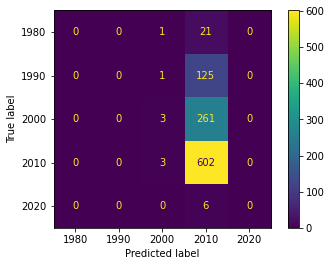

In [43]:
ConfusionMatrixDisplay.from_predictions(
    aug_test.classes, 
    np.argmax(model8.predict(aug_test), axis=1), 
    display_labels=list(aug_test.class_indices.keys()));

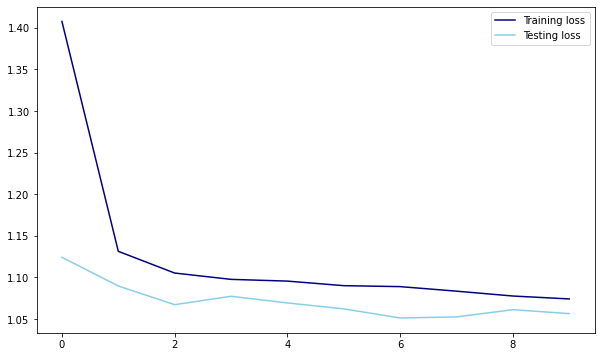

In [44]:
train_loss = history8.history['loss']
test_loss = history8.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

#### EfficientNet

In [45]:
eff_train_gen = ImageDataGenerator(vertical_flip=True, rotation_range=20)
eff_test_gen = ImageDataGenerator(vertical_flip=True, rotation_range=20)

In [46]:
eff_aug_train = eff_train_gen.flow_from_dataframe(
    dataframe=train,
    directory='/content/224x224',
    x_col='filename',
    y_col='decade',
    class_mode='categorical',
    target_size=(224,224)
)

eff_aug_test = eff_test_gen.flow_from_dataframe(
    dataframe=test,
    directory='/content/224x224',
    x_col='filename',
    y_col='decade',
    class_mode='categorical',
    target_size=(224,224),
    shuffle=False
)

Found 9117 validated image filenames belonging to 5 classes.
Found 1023 validated image filenames belonging to 5 classes.


In [47]:
effnet = EfficientNetB0(include_top=False, weights='imagenet')

16719872/16705208 [==============================] - 0s 0us/step


In [48]:
effnet.trainable = False

In [49]:
model9 = Sequential()
model9.add(effnet)
model9.add(GlobalAveragePooling2D())
model9.add(Dense(64, activation='relu'))
model9.add(Dense(5, activation='softmax'))

model9.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)

In [50]:
history9 = model9.fit(
    eff_aug_train,
    batch_size=32,
    validation_data=eff_aug_test,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
285/285 [==============================] - 150s 500ms/step - loss: 1.0816 - accuracy: 0.5649 - val_loss: 1.0072 - val_accuracy: 0.5836
Epoch 2/10
285/285 [==============================] - 141s 494ms/step - loss: 1.0054 - accuracy: 0.5892 - val_loss: 0.9986 - val_accuracy: 0.5894
Epoch 3/10
285/285 [==============================] - 139s 487ms/step - loss: 0.9779 - accuracy: 0.6006 - val_loss: 0.9870 - val_accuracy: 0.6051
Epoch 4/10
285/285 [==============================] - 140s 491ms/step - loss: 0.9602 - accuracy: 0.6135 - val_loss: 0.9794 - val_accuracy: 0.6061
Epoch 5/10
285/285 [==============================] - 140s 492ms/step - loss: 0.9444 - accuracy: 0.6151 - val_loss: 0.9795 - val_accuracy: 0.5973
Epoch 6/10
285/285 [==============================] - 140s 490ms/step - loss: 0.9324 - accuracy: 0.6217 - val_loss: 0.9768 - val_accuracy: 0.5973
Epoch 7/10
285/285 [==============================] - 138s 484ms/step - loss: 0.9238 - accuracy: 0.6253 - val_loss: 0.9671 -

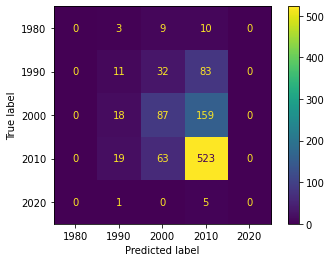

In [51]:
ConfusionMatrixDisplay.from_predictions(
    eff_aug_test.classes, 
    np.argmax(model9.predict(eff_aug_test), axis=1), 
    display_labels=list(eff_aug_test.class_indices.keys()));

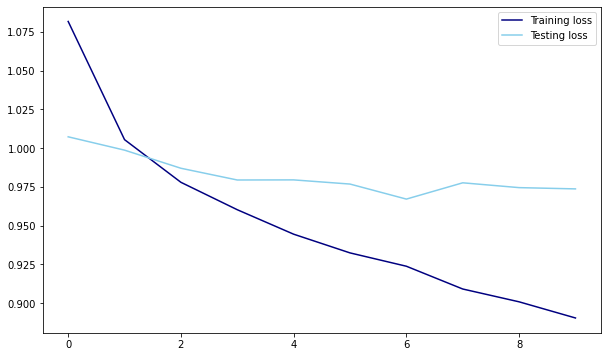

In [52]:
train_loss = history9.history['loss']
test_loss = history9.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

#### EffNet with Class Weights

In [53]:
# https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory/67678399#67678399

class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(eff_aug_train.classes), 
            y = eff_aug_train.classes)

train_class_weights = dict(enumerate(class_weights))

In [54]:
model10 = Sequential()
model10.add(effnet)
model10.add(GlobalAveragePooling2D())
model10.add(Dense(64, activation='relu'))
model10.add(Dense(5, activation='softmax'))

model10.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)

In [55]:
history10 = model10.fit(
    eff_aug_train,
    class_weight=train_class_weights,
    batch_size=32,
    validation_data=eff_aug_test,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 145s 484ms/step - loss: 1.5795 - accuracy: 0.2481 - val_loss: 1.5802 - val_accuracy: 0.2493
Epoch 2/100
285/285 [==============================] - 138s 484ms/step - loss: 1.4808 - accuracy: 0.2904 - val_loss: 1.5228 - val_accuracy: 0.3011
Epoch 3/100
285/285 [==============================] - 137s 481ms/step - loss: 1.4161 - accuracy: 0.3198 - val_loss: 1.5049 - val_accuracy: 0.3294
Epoch 4/100
285/285 [==============================] - 136s 478ms/step - loss: 1.3648 - accuracy: 0.3428 - val_loss: 1.5137 - val_accuracy: 0.3060
Epoch 5/100
285/285 [==============================] - 136s 478ms/step - loss: 1.3250 - accuracy: 0.3612 - val_loss: 1.5238 - val_accuracy: 0.3118
Epoch 6/100
285/285 [==============================] - 134s 470ms/step - loss: 1.2712 - accuracy: 0.3815 - val_loss: 1.5089 - val_accuracy: 0.2991
Epoch 7/100
285/285 [==============================] - 133s 466ms/step - loss: 1.2482 - accuracy: 0.3814 - val_loss: 1

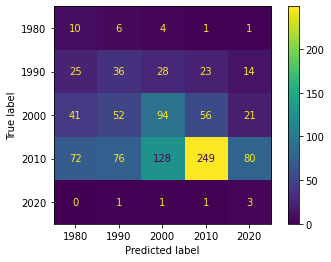

In [56]:
ConfusionMatrixDisplay.from_predictions(
    eff_aug_test.classes, 
    np.argmax(model10.predict(eff_aug_test), axis=1), 
    display_labels=list(eff_aug_test.class_indices.keys()));

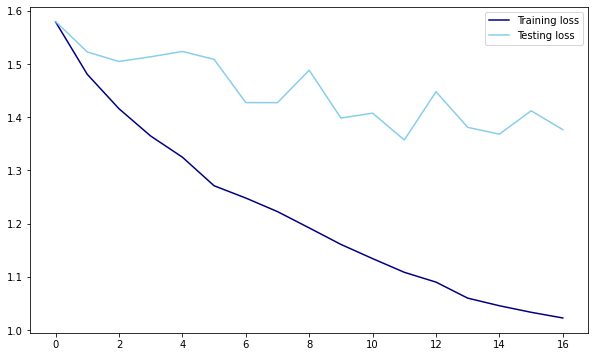

In [57]:
train_loss = history10.history['loss']
test_loss = history10.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

##### EffNet with Class Weights - Changing Learning Rate

In [58]:
model12 = Sequential()
model12.add(effnet)
model12.add(GlobalAveragePooling2D())
model12.add(Dense(64, activation='relu'))
model12.add(Dense(5, activation='softmax'))

model12.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)

In [59]:
history12 = model12.fit(
    eff_aug_train,
    class_weight=train_class_weights,
    batch_size=32,
    validation_data=eff_aug_test,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 150s 499ms/step - loss: 1.5414 - accuracy: 0.2872 - val_loss: 1.4987 - val_accuracy: 0.3177
Epoch 2/100
285/285 [==============================] - 141s 496ms/step - loss: 1.3459 - accuracy: 0.3464 - val_loss: 1.4949 - val_accuracy: 0.3187
Epoch 3/100
285/285 [==============================] - 141s 495ms/step - loss: 1.2443 - accuracy: 0.3919 - val_loss: 1.5064 - val_accuracy: 0.3284
Epoch 4/100
285/285 [==============================] - 140s 491ms/step - loss: 1.1372 - accuracy: 0.4155 - val_loss: 1.5797 - val_accuracy: 0.2952
Epoch 5/100
285/285 [==============================] - 142s 497ms/step - loss: 1.0621 - accuracy: 0.4523 - val_loss: 1.4436 - val_accuracy: 0.3617
Epoch 6/100
285/285 [==============================] - 143s 501ms/step - loss: 0.9637 - accuracy: 0.4744 - val_loss: 1.4466 - val_accuracy: 0.3529
Epoch 7/100
285/285 [==============================] - 142s 500ms/step - loss: 0.9161 - accuracy: 0.5012 - val_loss: 1

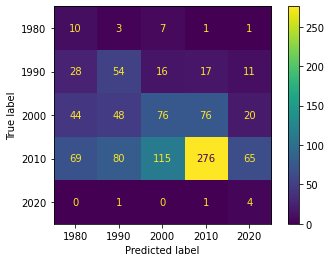

In [60]:
ConfusionMatrixDisplay.from_predictions(
    eff_aug_test.classes, 
    np.argmax(model12.predict(eff_aug_test), axis=1), 
    display_labels=list(eff_aug_test.class_indices.keys()));

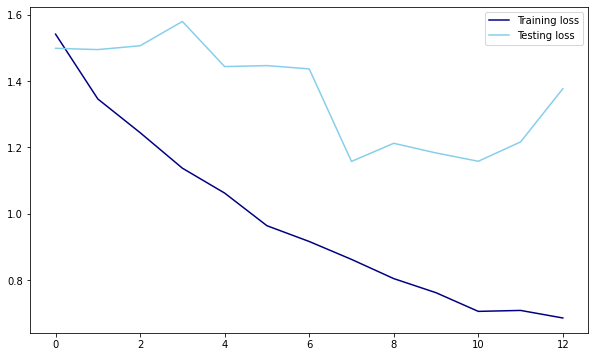

In [61]:
train_loss = history12.history['loss']
test_loss = history12.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

#### EffNet with Class Rates - Changing Dense Layer Nodes

In [62]:
model13 = Sequential()
model13.add(effnet)
model13.add(GlobalAveragePooling2D())
model13.add(Dense(128, activation='relu'))
model13.add(Dense(5, activation='softmax'))

model13.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)

In [63]:
history13 = model13.fit(
    eff_aug_train,
    class_weight=train_class_weights,
    batch_size=32,
    validation_data=eff_aug_test,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 151s 506ms/step - loss: 1.5777 - accuracy: 0.2931 - val_loss: 1.5913 - val_accuracy: 0.2542
Epoch 2/100
285/285 [==============================] - 143s 503ms/step - loss: 1.4462 - accuracy: 0.3066 - val_loss: 1.5095 - val_accuracy: 0.3304
Epoch 3/100
285/285 [==============================] - 143s 502ms/step - loss: 1.3792 - accuracy: 0.3487 - val_loss: 1.4919 - val_accuracy: 0.3245
Epoch 4/100
285/285 [==============================] - 143s 501ms/step - loss: 1.3087 - accuracy: 0.3670 - val_loss: 1.4553 - val_accuracy: 0.3500
Epoch 5/100
285/285 [==============================] - 140s 492ms/step - loss: 1.2645 - accuracy: 0.4010 - val_loss: 1.4265 - val_accuracy: 0.3607
Epoch 6/100
285/285 [==============================] - 141s 494ms/step - loss: 1.2109 - accuracy: 0.4206 - val_loss: 1.5682 - val_accuracy: 0.2757
Epoch 7/100
285/285 [==============================] - 140s 492ms/step - loss: 1.1817 - accuracy: 0.4263 - val_loss: 1

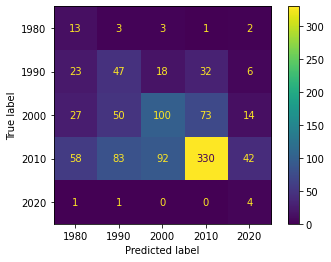

In [64]:
ConfusionMatrixDisplay.from_predictions(
    eff_aug_test.classes, 
    np.argmax(model13.predict(eff_aug_test), axis=1), 
    display_labels=list(eff_aug_test.class_indices.keys()));

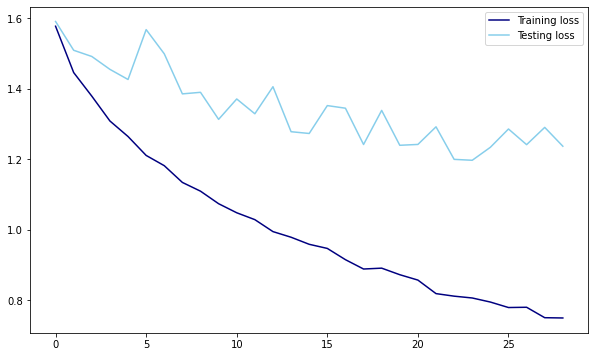

In [65]:
train_loss = history13.history['loss']
test_loss = history13.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

### Basic CNN with Weighted Classes

In [66]:
datagen_2 = ImageDataGenerator(rescale=1/255)

In [67]:
train_gen_2 = datagen_2.flow_from_dataframe(
    dataframe=train,
    directory='/content/224x224',
    x_col='filename',
    y_col='decade',
    class_mode='categorical',
    target_size=(256,256)
)

test_gen_2 = datagen_2.flow_from_dataframe(
    dataframe=test,
    directory='/content/224x224',
    x_col='filename',
    y_col='decade',
    class_mode='categorical',
    target_size=(256,256),
    shuffle=False
)

Found 9117 validated image filenames belonging to 5 classes.
Found 1023 validated image filenames belonging to 5 classes.


In [68]:
model11 = Sequential()
model11.add(Conv2D(64,(3,3),activation='relu',input_shape=(256,256,3)))
model11.add(MaxPooling2D(pool_size=(2,2)))

model11.add(Conv2D(64,(3,3),activation='relu'))
model11.add(MaxPooling2D(pool_size=(2,2)))

model11.add(Conv2D(64,(3,3),activation='relu'))
model11.add(MaxPooling2D(pool_size=(2,2)))

model11.add(Conv2D(64,(3,3),activation='relu'))
model11.add(MaxPooling2D(pool_size=(2,2)))

model11.add(Flatten())
model11.add(Dense(64,activation='relu'))
model11.add(Dropout(0.2))
model11.add(Dense(5,activation='softmax'))

model11.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [69]:
history11 = model11.fit(
    train_gen_2,
    class_weight=train_class_weights,
    validation_data=test_gen_2,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 36s 124ms/step - loss: 1.6175 - accuracy: 0.2899 - val_loss: 1.6095 - val_accuracy: 0.0362
Epoch 2/100
285/285 [==============================] - 35s 124ms/step - loss: 1.5886 - accuracy: 0.2145 - val_loss: 1.5612 - val_accuracy: 0.2092
Epoch 3/100
285/285 [==============================] - 37s 129ms/step - loss: 1.5633 - accuracy: 0.2072 - val_loss: 1.5451 - val_accuracy: 0.1984
Epoch 4/100
285/285 [==============================] - 36s 127ms/step - loss: 1.5324 - accuracy: 0.2487 - val_loss: 1.5572 - val_accuracy: 0.1760
Epoch 5/100
285/285 [==============================] - 35s 123ms/step - loss: 1.4727 - accuracy: 0.2483 - val_loss: 1.3945 - val_accuracy: 0.3363
Epoch 6/100
285/285 [==============================] - 36s 124ms/step - loss: 1.4042 - accuracy: 0.2801 - val_loss: 1.3507 - val_accuracy: 0.3861
Epoch 7/100
285/285 [==============================] - 36s 126ms/step - loss: 1.3010 - accuracy: 0.3273 - val_loss: 1.4716 -

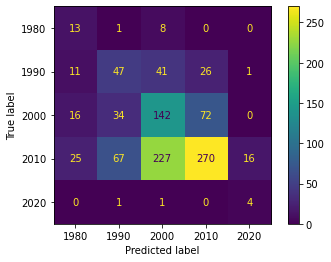

In [70]:
ConfusionMatrixDisplay.from_predictions(
    test_gen_2.classes, 
    np.argmax(model11.predict(test_gen_2), axis=1), 
    display_labels=list(test_gen_2.class_indices.keys()));

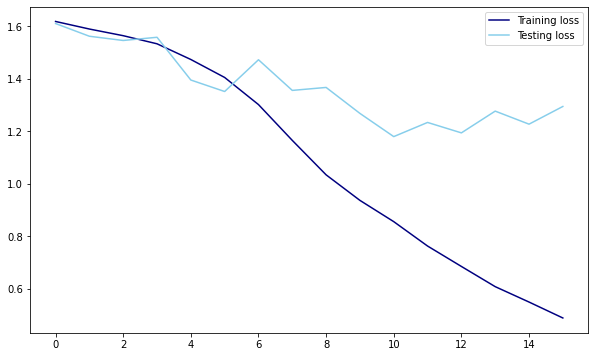

In [71]:
train_loss = history11.history['loss']
test_loss = history11.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

#### CNN with Weighted Classes, Altering Parameters

In [72]:
model14 = Sequential()
model14.add(Conv2D(64,(3,3),activation='relu',input_shape=(256,256,3)))
model14.add(MaxPooling2D(pool_size=(2,2)))

model14.add(Conv2D(64,(3,3),activation='relu'))
model14.add(MaxPooling2D(pool_size=(2,2)))

model14.add(Conv2D(64,(3,3),activation='relu'))
model14.add(MaxPooling2D(pool_size=(2,2)))

model14.add(Conv2D(64,(3,3),activation='relu'))
model14.add(MaxPooling2D(pool_size=(2,2)))

model14.add(Flatten())
model14.add(Dense(128,activation='relu'))
model14.add(Dropout(0.5))
model14.add(Dense(5,activation='softmax'))

model14.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [73]:
history14 = model14.fit(
    train_gen_2,
    class_weight=train_class_weights,
    validation_data=test_gen_2,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 36s 124ms/step - loss: 1.6169 - accuracy: 0.3213 - val_loss: 1.5862 - val_accuracy: 0.5914
Epoch 2/100
285/285 [==============================] - 34s 118ms/step - loss: 1.6020 - accuracy: 0.3264 - val_loss: 1.5863 - val_accuracy: 0.2825
Epoch 3/100
285/285 [==============================] - 34s 118ms/step - loss: 1.5898 - accuracy: 0.2464 - val_loss: 1.5481 - val_accuracy: 0.3812
Epoch 4/100
285/285 [==============================] - 33s 117ms/step - loss: 1.5586 - accuracy: 0.2490 - val_loss: 1.5762 - val_accuracy: 0.1447
Epoch 5/100
285/285 [==============================] - 34s 118ms/step - loss: 1.5343 - accuracy: 0.2412 - val_loss: 1.5173 - val_accuracy: 0.2532
Epoch 6/100
285/285 [==============================] - 34s 118ms/step - loss: 1.4946 - accuracy: 0.2647 - val_loss: 1.5734 - val_accuracy: 0.1320
Epoch 7/100
285/285 [==============================] - 34s 117ms/step - loss: 1.3929 - accuracy: 0.2800 - val_loss: 1.4641 -

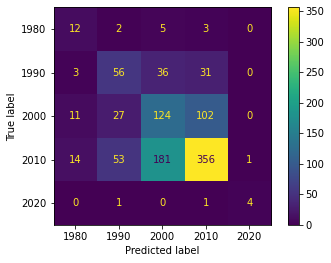

In [74]:
ConfusionMatrixDisplay.from_predictions(
    test_gen_2.classes, 
    np.argmax(model14.predict(test_gen_2), axis=1), 
    display_labels=list(test_gen_2.class_indices.keys()));

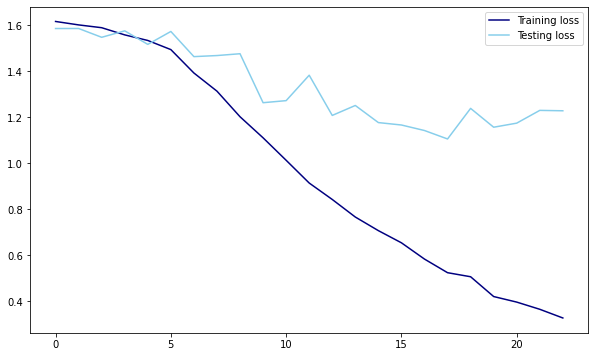

In [75]:
train_loss = history14.history['loss']
test_loss = history14.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

In [76]:
model15 = Sequential()
model15.add(Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)))
model15.add(MaxPooling2D(pool_size=(2,2)))

model15.add(Conv2D(32,(3,3),activation='relu'))
model15.add(MaxPooling2D(pool_size=(2,2)))

model15.add(Conv2D(64,(3,3),activation='relu'))
model15.add(MaxPooling2D(pool_size=(2,2)))

model15.add(Conv2D(64,(3,3),activation='relu'))
model15.add(MaxPooling2D(pool_size=(2,2)))

model15.add(Conv2D(128,(3,3),activation='relu'))
model15.add(MaxPooling2D(pool_size=(2,2)))

model15.add(Flatten())
model15.add(Dense(128,activation='relu'))
model15.add(Dropout(0.4))
model15.add(Dense(5,activation='softmax'))

model15.compile(
    optimizer = Adam(learning_rate=.00001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [77]:
history15 = model15.fit(
    train_gen_2,
    class_weight=train_class_weights,
    validation_data=test_gen_2,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 33s 112ms/step - loss: 1.6091 - accuracy: 0.2556 - val_loss: 1.5814 - val_accuracy: 0.5513
Epoch 2/100
285/285 [==============================] - 31s 109ms/step - loss: 1.6064 - accuracy: 0.3242 - val_loss: 1.5810 - val_accuracy: 0.5044
Epoch 3/100
285/285 [==============================] - 31s 109ms/step - loss: 1.6017 - accuracy: 0.2716 - val_loss: 1.6022 - val_accuracy: 0.1818
Epoch 4/100
285/285 [==============================] - 31s 110ms/step - loss: 1.5996 - accuracy: 0.2439 - val_loss: 1.5793 - val_accuracy: 0.4409
Epoch 5/100
285/285 [==============================] - 31s 110ms/step - loss: 1.5957 - accuracy: 0.3051 - val_loss: 1.5907 - val_accuracy: 0.2551
Epoch 6/100
285/285 [==============================] - 33s 115ms/step - loss: 1.5883 - accuracy: 0.2424 - val_loss: 1.5807 - val_accuracy: 0.2981
Epoch 7/100
285/285 [==============================] - 31s 109ms/step - loss: 1.5812 - accuracy: 0.2313 - val_loss: 1.5763 -

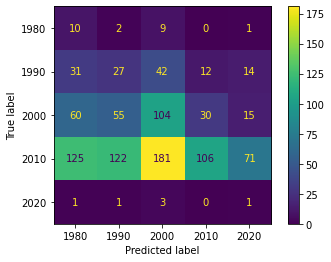

In [78]:
ConfusionMatrixDisplay.from_predictions(
    test_gen_2.classes, 
    np.argmax(model15.predict(test_gen_2), axis=1), 
    display_labels=list(test_gen_2.class_indices.keys()));

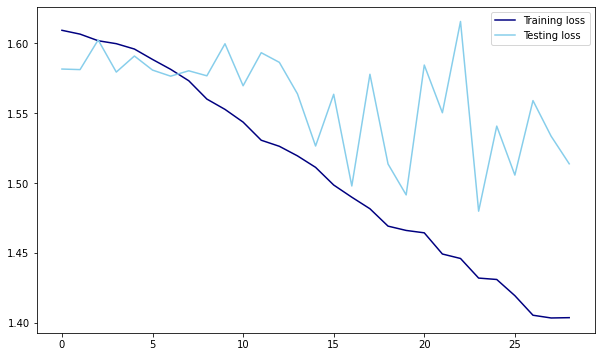

In [79]:
train_loss = history15.history['loss']
test_loss = history15.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

In [80]:
model16 = Sequential()
model16.add(Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)))
model16.add(MaxPooling2D(pool_size=(2,2)))

model16.add(Conv2D(64,(3,3),activation='relu'))
model16.add(MaxPooling2D(pool_size=(2,2)))

model16.add(Flatten())
model16.add(Dense(128,activation='relu'))
model16.add(Dropout(0.4))
model16.add(Dense(5,activation='softmax'))

model16.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [81]:
history16 = model16.fit(
    train_gen_2,
    class_weight=train_class_weights,
    validation_data=test_gen_2,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 31s 106ms/step - loss: 1.7524 - accuracy: 0.1904 - val_loss: 1.5719 - val_accuracy: 0.1613
Epoch 2/100
285/285 [==============================] - 30s 104ms/step - loss: 1.5109 - accuracy: 0.2450 - val_loss: 1.5350 - val_accuracy: 0.1965
Epoch 3/100
285/285 [==============================] - 30s 104ms/step - loss: 1.3784 - accuracy: 0.2903 - val_loss: 1.4612 - val_accuracy: 0.3275
Epoch 4/100
285/285 [==============================] - 30s 105ms/step - loss: 1.2177 - accuracy: 0.3540 - val_loss: 1.3086 - val_accuracy: 0.4301
Epoch 5/100
285/285 [==============================] - 31s 108ms/step - loss: 1.0294 - accuracy: 0.4251 - val_loss: 1.2822 - val_accuracy: 0.4555
Epoch 6/100
285/285 [==============================] - 30s 104ms/step - loss: 0.8905 - accuracy: 0.4754 - val_loss: 1.1860 - val_accuracy: 0.4995
Epoch 7/100
285/285 [==============================] - 30s 104ms/step - loss: 0.7762 - accuracy: 0.5349 - val_loss: 1.2184 -

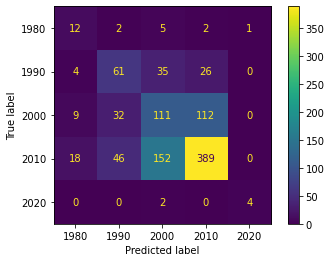

In [82]:
ConfusionMatrixDisplay.from_predictions(
    test_gen_2.classes, 
    np.argmax(model16.predict(test_gen_2), axis=1), 
    display_labels=list(test_gen_2.class_indices.keys()));

In [83]:
model17 = Sequential()

model17.add(Conv2D(64,(3,3),activation='relu'))
model17.add(MaxPooling2D(pool_size=(2,2)))

model17.add(Flatten())
model17.add(Dense(64,activation='relu'))
model17.add(Dropout(0.4))
model17.add(Dense(5,activation='softmax'))

model17.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [84]:
history17 = model17.fit(
    train_gen_2,
    class_weight=train_class_weights,
    validation_data=test_gen_2,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 33s 113ms/step - loss: 1.8149 - accuracy: 0.1249 - val_loss: 1.6101 - val_accuracy: 0.1222
Epoch 2/100
285/285 [==============================] - 33s 114ms/step - loss: 1.6088 - accuracy: 0.1268 - val_loss: 1.6098 - val_accuracy: 0.1232
Epoch 3/100
285/285 [==============================] - 34s 118ms/step - loss: 1.6084 - accuracy: 0.1266 - val_loss: 1.6100 - val_accuracy: 0.1232
Epoch 4/100
285/285 [==============================] - 32s 111ms/step - loss: 1.6104 - accuracy: 0.0800 - val_loss: 1.6102 - val_accuracy: 0.1232
Epoch 5/100
285/285 [==============================] - 32s 113ms/step - loss: 1.6095 - accuracy: 0.1564 - val_loss: 1.6102 - val_accuracy: 0.1232
Epoch 6/100
285/285 [==============================] - 32s 112ms/step - loss: 1.6082 - accuracy: 0.0487 - val_loss: 1.6100 - val_accuracy: 0.1232
Epoch 7/100
285/285 [==============================] - 32s 111ms/step - loss: 1.6082 - accuracy: 0.0473 - val_loss: 1.6100 -

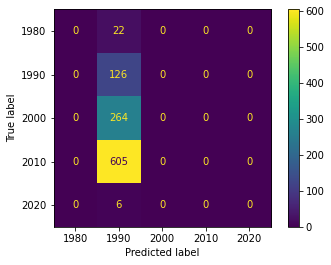

In [85]:
ConfusionMatrixDisplay.from_predictions(
    test_gen_2.classes, 
    np.argmax(model17.predict(test_gen_2), axis=1), 
    display_labels=list(test_gen_2.class_indices.keys()));

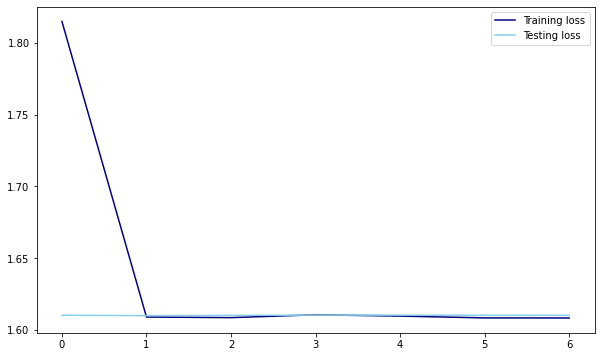

In [86]:
train_loss = history17.history['loss']
test_loss = history17.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

### Data Augmentation with Weighted Classes

In [87]:
aug_train_gen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2
)

datagen = ImageDataGenerator(rescale=1/255)

In [88]:
aug_train = aug_train_gen.flow_from_dataframe(
    dataframe=train,
    directory='/content/224x224',
    x_col='filename',
    y_col='decade',
    class_mode='categorical',
    target_size=(256,256)
)

aug_test = datagen.flow_from_dataframe(
    dataframe=test,
    directory='/content/224x224',
    x_col='filename',
    y_col='decade',
    class_mode='categorical',
    target_size=(256,256),
    shuffle=False
)

Found 9117 validated image filenames belonging to 5 classes.
Found 1023 validated image filenames belonging to 5 classes.


In [89]:
# https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory/67678399#67678399

class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(aug_train.classes), 
            y = aug_train.classes)

train_class_weights = dict(enumerate(class_weights))

In [90]:
model18 = Sequential()
model18.add(Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)))
model18.add(MaxPooling2D(pool_size=(2,2)))

model18.add(Conv2D(64,(3,3),activation='relu'))
model18.add(MaxPooling2D(pool_size=(2,2)))

model18.add(Flatten())
model18.add(Dense(128,activation='relu'))
model18.add(Dropout(0.4))
model18.add(Dense(5,activation='softmax'))

model18.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [91]:
history18 = model18.fit(
    aug_train,
    class_weight=train_class_weights,
    validation_data=aug_test,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 152s 531ms/step - loss: 1.6857 - accuracy: 0.1730 - val_loss: 1.6278 - val_accuracy: 0.0880
Epoch 2/100
285/285 [==============================] - 150s 527ms/step - loss: 1.6092 - accuracy: 0.1148 - val_loss: 1.6097 - val_accuracy: 0.1261
Epoch 3/100
285/285 [==============================] - 151s 530ms/step - loss: 1.6094 - accuracy: 0.1269 - val_loss: 1.6097 - val_accuracy: 0.1251
Epoch 4/100
285/285 [==============================] - 151s 530ms/step - loss: 1.6105 - accuracy: 0.1168 - val_loss: 1.6119 - val_accuracy: 0.0714
Epoch 5/100
285/285 [==============================] - 149s 523ms/step - loss: 1.6067 - accuracy: 0.1573 - val_loss: 1.6087 - val_accuracy: 0.2258
Epoch 6/100
285/285 [==============================] - 151s 528ms/step - loss: 1.6044 - accuracy: 0.2247 - val_loss: 1.6102 - val_accuracy: 0.2522
Epoch 7/100
285/285 [==============================] - 150s 528ms/step - loss: 1.6096 - accuracy: 0.2492 - val_loss: 1

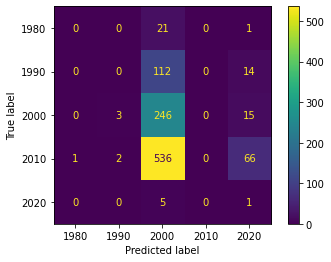

In [92]:
ConfusionMatrixDisplay.from_predictions(
    aug_test.classes, 
    np.argmax(model18.predict(aug_test), axis=1), 
    display_labels=list(aug_test.class_indices.keys()));

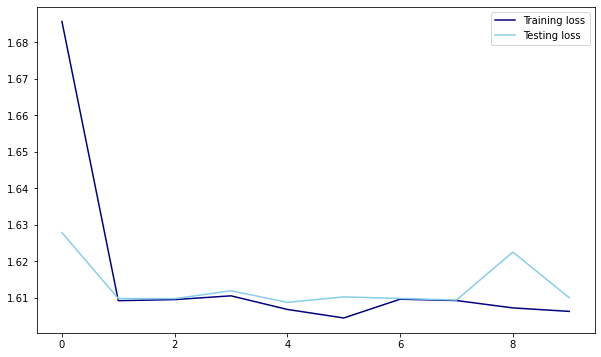

In [93]:
train_loss = history18.history['loss']
test_loss = history18.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

### CNN Model with Different Hyperparameter Changes

In [94]:
model19 = Sequential()
model19.add(Conv2D(128,(4,4),activation='relu',input_shape=(256,256,3)))
model19.add(MaxPooling2D(pool_size=(2,2)))

model19.add(Conv2D(16,(4,4),activation='relu'))
model19.add(MaxPooling2D(pool_size=(2,2)))

model19.add(Conv2D(32,(3,3),activation='relu'))
model19.add(MaxPooling2D(pool_size=(2,2)))

model19.add(Conv2D(128,(4,4),activation='relu'))
model19.add(MaxPooling2D(pool_size=(2,2)))

model19.add(Flatten())
model19.add(Dense(32,activation='relu'))
model19.add(Dropout(0.1))
model19.add(Dense(5,activation='softmax'))

model19.compile(
    optimizer = Adam(learning_rate=.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [95]:
history19 = model19.fit(
    train_gen_2,
    class_weight=train_class_weights,
    validation_data=test_gen_2,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
285/285 [==============================] - 42s 142ms/step - loss: 1.6150 - accuracy: 0.5323 - val_loss: 1.5972 - val_accuracy: 0.5816
Epoch 2/100
285/285 [==============================] - 38s 134ms/step - loss: 1.6052 - accuracy: 0.4510 - val_loss: 1.5231 - val_accuracy: 0.1994
Epoch 3/100
285/285 [==============================] - 38s 133ms/step - loss: 1.5870 - accuracy: 0.3553 - val_loss: 1.5344 - val_accuracy: 0.2551
Epoch 4/100
285/285 [==============================] - 38s 132ms/step - loss: 1.5584 - accuracy: 0.2771 - val_loss: 1.5855 - val_accuracy: 0.0850
Epoch 5/100
285/285 [==============================] - 40s 139ms/step - loss: 1.5312 - accuracy: 0.3178 - val_loss: 1.5379 - val_accuracy: 0.2424
Epoch 6/100
285/285 [==============================] - 38s 133ms/step - loss: 1.5032 - accuracy: 0.3217 - val_loss: 1.5721 - val_accuracy: 0.1818
Epoch 7/100
285/285 [==============================] - 38s 133ms/step - loss: 1.4436 - accuracy: 0.3289 - val_loss: 1.5110 -

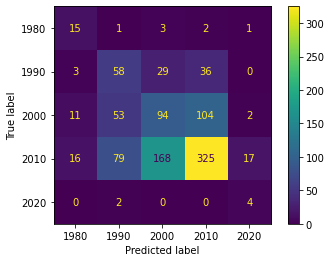

In [96]:
ConfusionMatrixDisplay.from_predictions(
    test_gen_2.classes, 
    np.argmax(model19.predict(test_gen_2), axis=1), 
    display_labels=list(test_gen_2.class_indices.keys()));

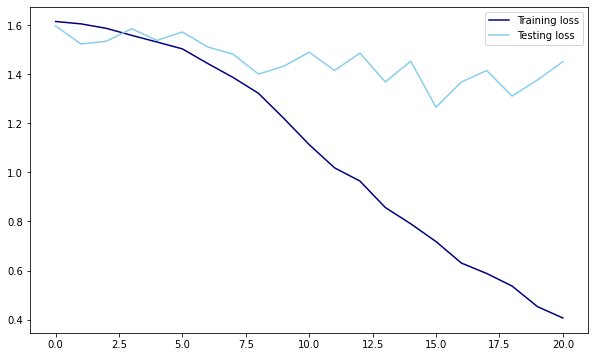

In [97]:
train_loss = history19.history['loss']
test_loss = history19.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();